In [207]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

In [2]:
viirs_tbl = ulmo_io.load_main_table( 's3://viirs/Tables/VIIRS_all_99clear_std.parquet')
viirs_tbl.head()

Read main table: s3://viirs/Tables/VIIRS_all_99clear_std.parquet


,filename,row,col,lat,lon,clear_fraction,field_size,datetime,ex_filename,pp_file,pp_root,pp_idx,pp_type,mean_temperature,Tmin,Tmax,T90,T10,LL
0,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2496,21.009575,-175.17024,0.004693,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,459126,0,26.149899,25.119995,26.790009,26.359985,25.950012,482.765015
1,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2592,20.876402,-175.80142,0.002740,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,379958,0,26.039507,24.489990,26.889984,26.309998,25.829987,493.697144
2,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3216,2688,20.725744,-176.50098,0.006565,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,217941,0,25.925251,23.980011,27.029999,26.359985,25.609985,328.781921
3,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3312,2496,21.622444,-175.36200,0.003906,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,455088,0,26.135242,25.160004,27.149994,26.399994,25.920013,447.812378
4,s3://viirs/data/2012/032/20120201001000-OSPO-L...,3408,1920,23.276363,-170.16823,0.003988,192,2012-02-01 00:10:00,s3://viirs/Extractions/VIIRS_2012_95clear_192x...,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_...,viirs_std,200120,0,26.035648,24.579987,27.320007,26.600006,25.359985,308.331177


In [25]:
slice1 = viirs_tbl[ (viirs_tbl.LL > 550) ]  #& (viirs_tbl.LL < 200)]
slice1.shape

(325938, 19)

In [23]:
slice2 = viirs_tbl[ (viirs_tbl.LL < 0)]
slice2.shape

(319156, 19)

In [104]:
def evals_to_healpix(eval_tbl, nside, mask=True):
    """
    Generate a healpix map of where the input
    MHW Systems are located on the globe
    Parameters
    ----------
    mhw_sys : pandas.DataFrame
    nside : int  # nside is a number that sets the resolution of map
    mask : bool, optional
    Returns
    -------
    healpix_array : hp.ma (number of cutouts)
    lats : np.ndarray
    lons : np.ndarray
    """
    # Grab lats, lons
    lats = eval_tbl.lat.values
    lons = eval_tbl.lon.values

    # Healpix coords
    theta = (90 - lats) * np.pi / 180. 
    phi = lons * np.pi / 180.
    idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) 

    # Count events
    npix_hp = hp.nside2npix(nside)
    all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int'))  

    for i, idx in enumerate(idx_all):
        all_events[idx] += 1

    zero = all_events == 0 
    
    float_events = all_events.astype(float)


    # Mask
    hpma = hp.ma(float_events)
    if mask:  # if you want to mask float_events
        hpma.mask = zero # current mask set to zero array, where Trues (no events) are masked

    # Angles
    hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

    # Return
    return hpma, hp_lons, hp_lats

In [214]:
hp_events1, hp_lons1, hp_lats1 = evals_to_healpix(
        slice1, nside=64, mask=True)
    
hp_events2, hp_lons2, hp_lats2= evals_to_healpix(
        slice2, nside=64, mask=True)

In [215]:
a = (hp_events1.mask == False) 

In [216]:
b = (hp_events2.mask == False)

In [187]:
a

array([False, False, False, ..., False, False, False])

In [217]:
c = a & (a == b)
c.shape

(49152,)

In [218]:
d = a & ~c
d

array([False, False, False, ..., False, False, False])

In [184]:
True in d

False

In [127]:
~both

array([ True,  True,  True, ...,  True,  True,  True])

In [208]:
a

array([False, False, False, ..., False, False, False])

In [224]:
np.max( hp_events1 )

1208.0

In [119]:
idxs = np.where( c == True)
idxs

(array([  286,   330,   336, ..., 48507, 48575, 48576]),)

In [229]:
def show_spatial_diff(sub_tbl1:pd.DataFrame, sub_tbl2:pd.DataFrame,
                 nside=64, use_log=True, 
                 use_mask=True,
                 lbl1=None, lbl2=None, figsize=(24,16), 
                 color ='coolwarm', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1= evals_to_healpix(
        sub_tbl1, nside, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2= evals_to_healpix(
        sub_tbl2, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    cm = plt.get_cmap(color)
    
    # Masks
    
    
    a = (hp_events1.mask == False)
    b = (hp_events2.mask == False)
    both = a & (a == b)
    
    
    good1 = a & ( ~both)
    good2 = b & ( ~both)
    
    
    # Cut
    img1 = plt.scatter(x=hp_lons1[good1],
        y=hp_lats1[good1],
        c= cm(0),
        s=5,
        transform=tformP)
    
    img2 = plt.scatter(x=hp_lons2[good2],
        y=hp_lats2[good2],
        c=cm(1),
        s=5,
        transform=tformP)
    
    img3 = plt.scatter(x=hp_lons2[both],
        y=hp_lats2[both],
        c=hp_events1[both] - hp_events2[both], vmin = -500, vmax = 500,
        cmap=cm,
        s=5,
        transform=tformP) 
    #c=hp_events2[both]

    # Colorbar
    cb = plt.colorbar(img3, orientation='vertical', location = 'right',shrink = 0.25)
    
    if lbl1 is not None and lbl2 is not None:
        clbl='{} - {}'.format(lbl1, lbl2)
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)
    

    # Coast lines
    ax.coastlines(zorder=10)
    ax.set_global()

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
        color='black', alpha=0.5, linestyle=':', draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right=False
    gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
    gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}


    # Layout and save
    if show:
        plt.show()

    return ax

In [30]:
slice1.shape

(325938, 19)

In [57]:
False in hp_events1.mask

True

In [58]:
both = (hp_events1.mask == False) & (hp_events2.mask ==False)

In [59]:
np.where(True in both)

(array([0]),)

#### False == events

In [81]:
a = np.array( [True, False, True, True, False])
a

array([ True, False,  True,  True, False])

In [82]:
b = np.array( [True, True, False, True, False])
b

array([ True,  True, False,  True, False])

In [83]:
(a == False) & (b == False) 

array([False, False, False, False,  True])

In [41]:
(a == b) & (b == False) 

array([False, False, False, False,  True])

In [36]:
a == b

array([ True, False, False,  True,  True])

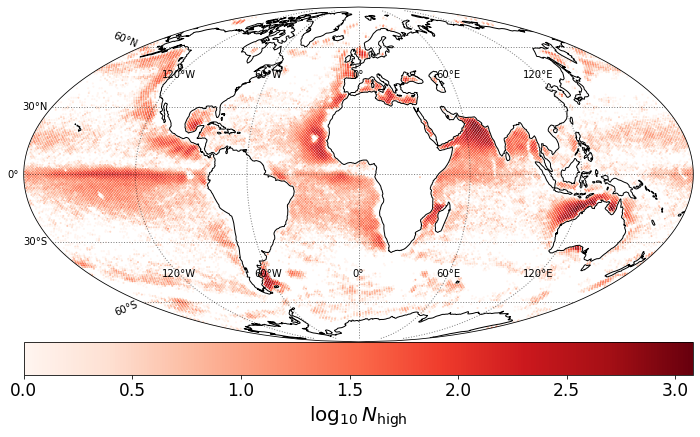

In [38]:
_ = ulmo_figs.show_spatial(slice1, lbl = 'high')

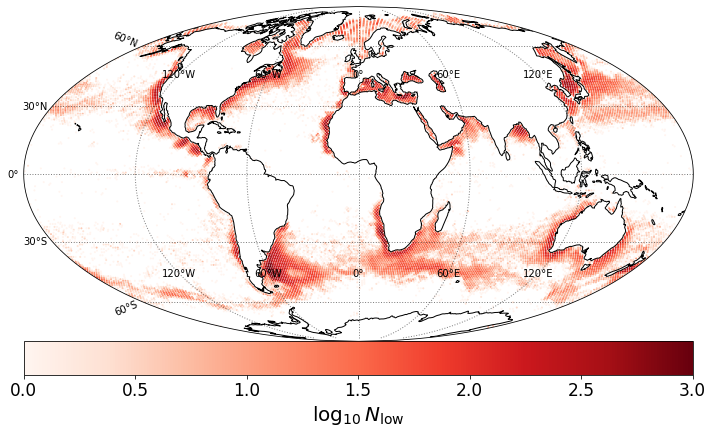

In [39]:
_ = ulmo_figs.show_spatial(slice2, lbl = 'low')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


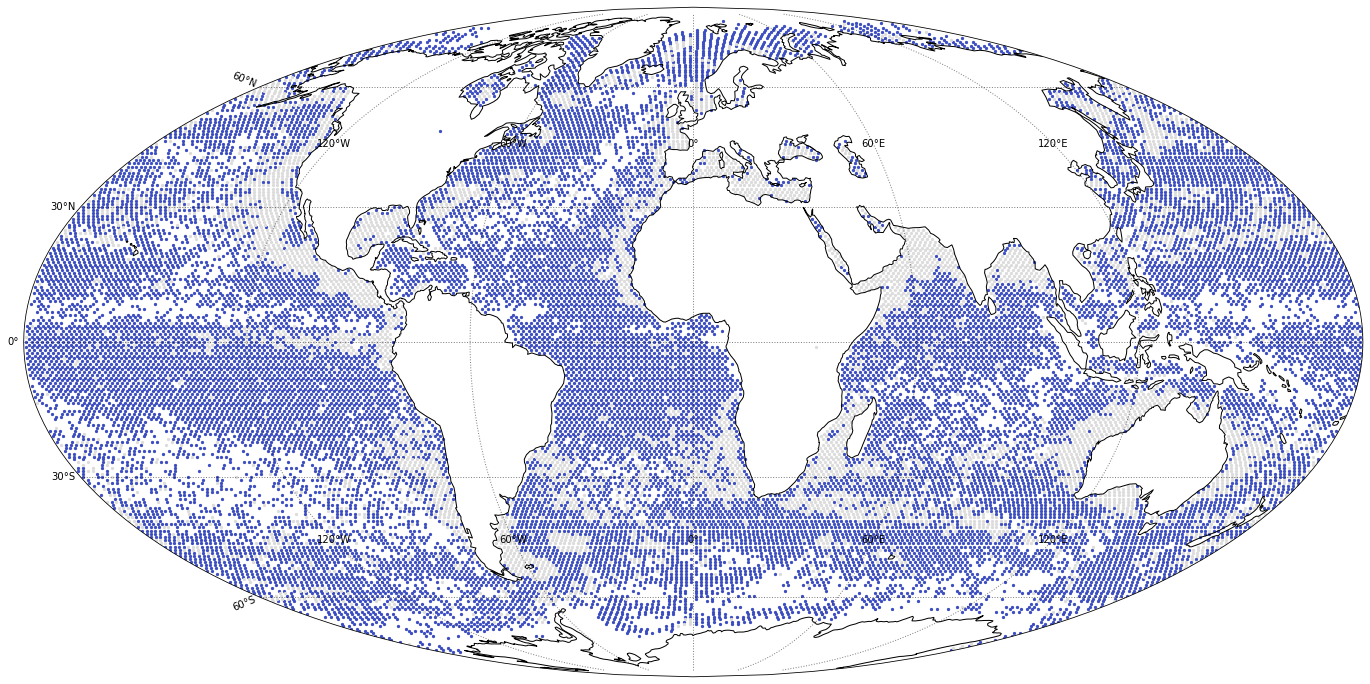

<GeoAxesSubplot:>

In [230]:
show_spatial_diff(slice1, slice2)

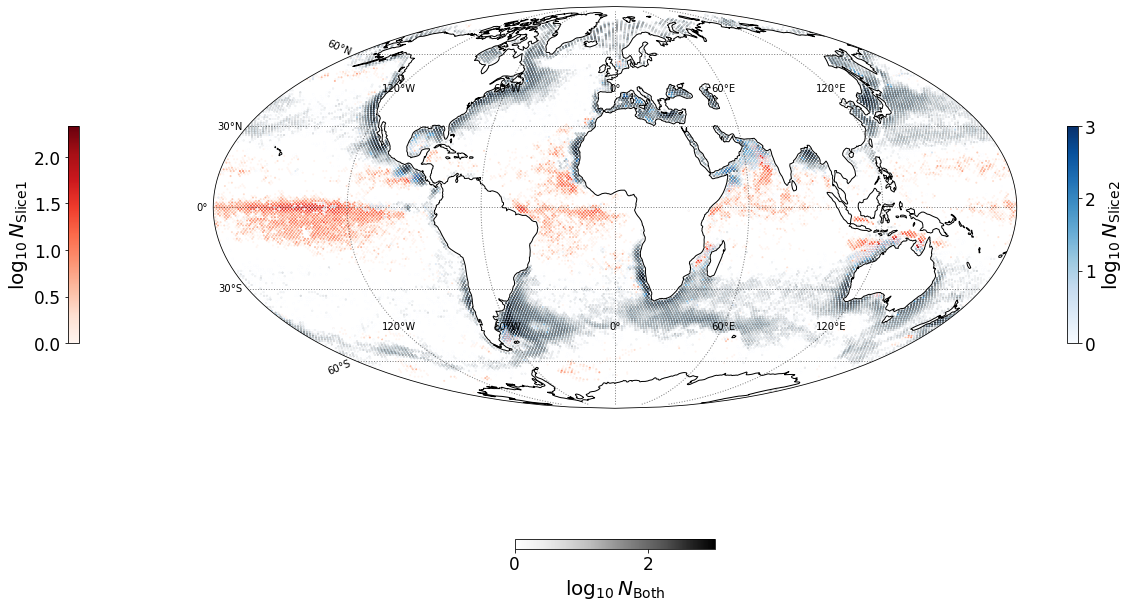

<GeoAxesSubplot:>

In [54]:
show_spatial(slice1, slice2, lbl1 = 'Slice 1', lbl2 = 'Slice 2', lbl3='Both')

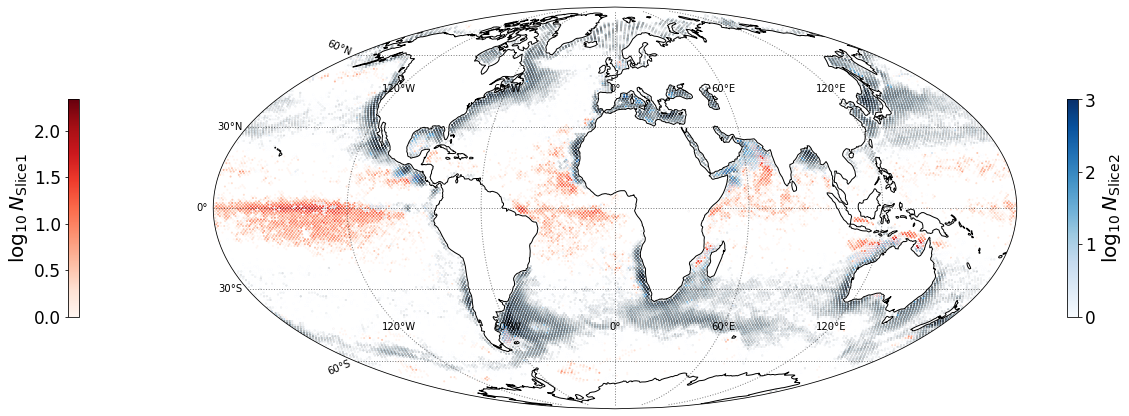

<GeoAxesSubplot:>

In [44]:
show_spatial(slice1, slice2, lbl1 = 'Slice 1', lbl2 = 'Slice 2')

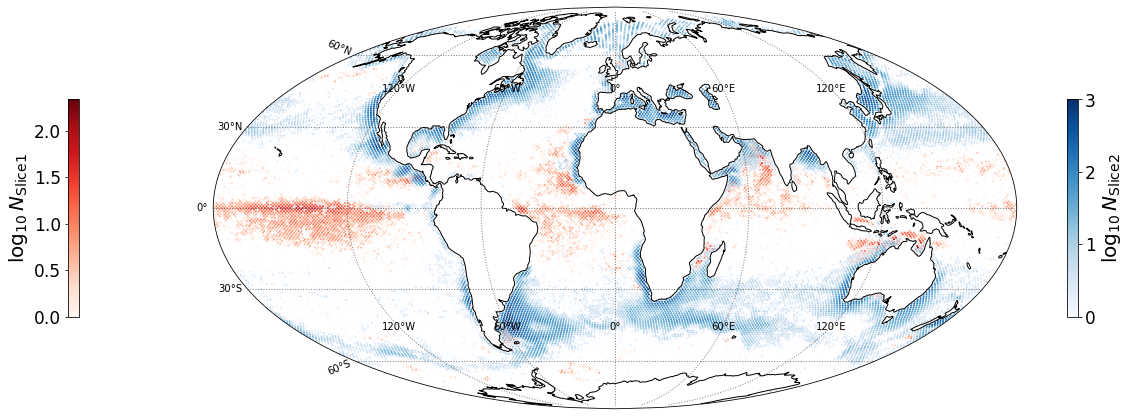

<GeoAxesSubplot:>

In [24]:
sp.show_spatial_two_slices(slice1, slice2, lbl1 = 'Slice 1', lbl2 = 'Slice 2')

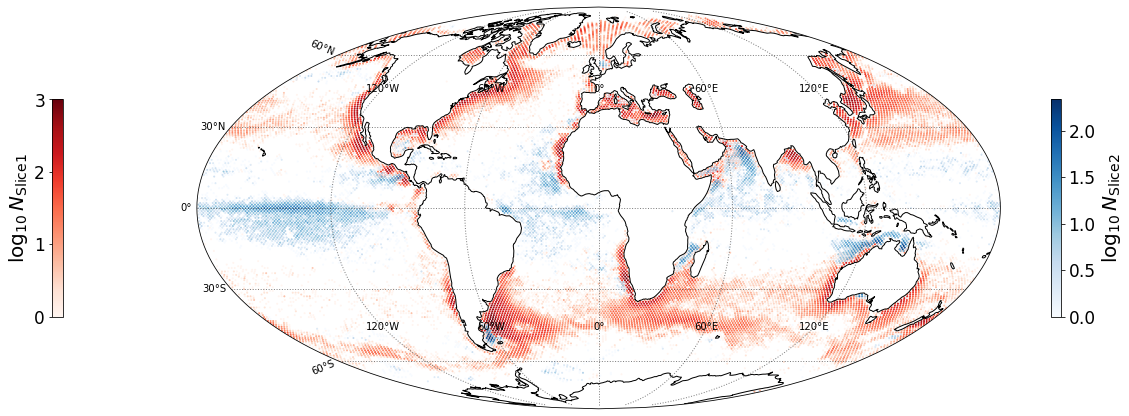

<GeoAxesSubplot:>

In [51]:
sp.show_spatial_two_slices(slice2, slice1, lbl1 = 'Slice 1', lbl2 = 'Slice 2')